In [144]:
import torch
from torch_geometric.data import Data
from e3nn import o3
from e3nn.nn import Gate, FullyConnectedNet
from e3nn.o3 import FullyConnectedTensorProduct


In [145]:
def create_random_molecule(num_atoms=5):
    pos = torch.randn(num_atoms, 3)
    edge_index = torch.combinations(torch.arange(num_atoms), r=2).T
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
    return Data(pos=pos, edge_index=edge_index)


In [146]:
data = create_random_molecule()
x = data.pos
edge_index = data.edge_index
edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 1, 2, 3, 4, 2, 3, 4, 3, 4, 4],
        [1, 2, 3, 4, 2, 3, 4, 3, 4, 4, 0, 0, 0, 0, 1, 1, 1, 2, 2, 3]])

In [147]:
edge_src, edge_dst = edge_index
edge_vec = x[edge_dst] - x[edge_src]
edge_attr = o3.spherical_harmonics(l=1, x=edge_vec, normalize=True, normalization='component')
node_attr = o3.spherical_harmonics(l=1, x=x, normalize=True, normalization='component')

In [148]:
print("Shape of x:", x.shape)
print("Shape of edge_vec:", edge_vec.shape)
print("Shape of edge_attr:", edge_attr.shape)
print("Shape of node_attr:", node_attr.shape)

Shape of x: torch.Size([5, 3])
Shape of edge_vec: torch.Size([20, 3])
Shape of edge_attr: torch.Size([20, 3])
Shape of node_attr: torch.Size([5, 3])


/home/hodaka/miniforge3/envs/ml/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


FullyConnectedTensorProduct(1x1o x 1x1o -> 16x0e+8x1o | 16 paths | 16 weights)

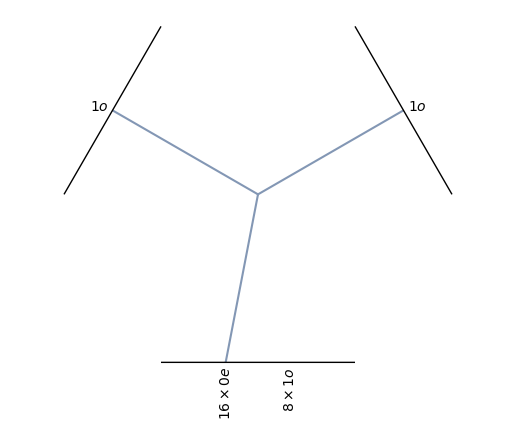

In [149]:
tp = FullyConnectedTensorProduct(
    irreps_in1=o3.Irreps("1o"),
    irreps_in2=o3.Irreps("1o"),
    irreps_out=o3.Irreps("16x0e + 8x1o")
    )
tp.visualize()
tp

In [150]:
print("\nInput irreps:")
print("irreps_in1:", tp.irreps_in1)
print("irreps_in2:", tp.irreps_in2)

print("\nOutput irreps:")
print("irreps_out:", tp.irreps_out)

# 期待される入力と出力の次元を確認
print("\nExpected dimensions:")
print("Input 1 dimension:", tp.irreps_in1.dim)
print("Input 2 dimension:", tp.irreps_in2.dim)
print("Output dimension:", tp.irreps_out.dim)


Input irreps:
irreps_in1: 1x1o
irreps_in2: 1x1o

Output irreps:
irreps_out: 16x0e+8x1o

Expected dimensions:
Input 1 dimension: 3
Input 2 dimension: 3
Output dimension: 40


In [151]:
x = tp(node_attr, node_attr)

In [154]:
print(tp.irreps_out)
print(x.shape)

16x0e+8x1o
torch.Size([5, 40])


In [155]:
gate = Gate(
    irreps_scalars=o3.Irreps("8x0e"),
    act_scalars=[torch.tanh],
    irreps_gates=o3.Irreps("8x0e"),  
    act_gates=[torch.tanh],
    irreps_gated=o3.Irreps("8x1o")
)

/home/hodaka/miniforge3/envs/ml/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


In [156]:
print("Gate input:", gate.irreps_in)
print("Gate scalars:", gate.irreps_scalars)
print("Gate gates:", gate.irreps_gates)
print("Gate gated:", gate.irreps_gated)
print("Gate output:", gate.irreps_out)

Gate input: 16x0e+8x1o
Gate scalars: 8x0e
Gate gates: 8x0e
Gate gated: 8x1o
Gate output: 8x0e+8x1o


In [157]:
x = gate(x)

In [158]:
fc_net = FullyConnectedNet(
    [gate.irreps_out.dim, 64, 1],  # 入力次元、中間層、出力次元
    act=torch.relu  # 活性化関数
)

In [160]:
print(fc_net.hs)

[32, 64, 1]


In [161]:
y = fc_net(x)

In [162]:
y

tensor([[-0.6025],
        [-0.6025],
        [-0.6025],
        [-0.6025],
        [-0.6025]], grad_fn=<MmBackward0>)

In [181]:
class EquivariantNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tp = FullyConnectedTensorProduct(
            irreps_in1=o3.Irreps("1o"),
            irreps_in2=o3.Irreps("1o"),
            irreps_out=o3.Irreps("16x0e + 8x1o")
        )
        self.gate = Gate(
            irreps_scalars=o3.Irreps("8x0e"),
            act_scalars=[torch.tanh],
            irreps_gates=o3.Irreps("8x0e"),  
            act_gates=[torch.tanh],
            irreps_gated=o3.Irreps("8x1o")
        )
        self.fc_net = FullyConnectedNet(
            [gate.irreps_out.dim, 64, 1],  # 入力次元、中間層、出力次元
            act=torch.relu  # 活性化関数
        )

    def forward(self, x):
        # edge_src, edge_dst = edge_index
        # edge_vec = x[edge_dst] - x[edge_src]
        # edge_attr = o3.spherical_harmonics(l=1, x=edge_vec, normalize=True, normalization='component')
        node_attr = o3.spherical_harmonics(l=1, x=x, normalize=True, normalization='component')
        x = self.tp(node_attr, node_attr)
        x = self.gate(x)
        y = self.fc_net(x)
        return y


In [182]:
data = create_random_molecule()
model = EquivariantNN()
x = data.pos
y = model(x)

/home/hodaka/miniforge3/envs/ml/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


In [183]:
x.shape

torch.Size([5, 3])

In [184]:
y.shape

torch.Size([5, 1])

In [4]:
def test_equivariance(model, data):
    print(f"Input shape: {data.pos.shape}")
    out1 = model(data.pos, data.edge_index)
    print(f"Output shape: {out1.shape}")
    print(f"Output type: {type(out1)}")

    # Apply random rotation
    R = o3.rand_matrix()
    rotated_pos = torch.einsum('ij,nj->ni', R, data.pos)
    out2 = model(rotated_pos, data.edge_index)
    rotated_out2 = torch.einsum('ij,nj->ni', R, out2)

    diff = (out1 - rotated_out2).abs().max().item()
    print(f"Maximum difference after rotation: {diff:.6f}")
    return diff < 1e-5

In [5]:
import torch
from torch_geometric.data import Data
from e3nn import o3
from e3nn.o3 import FullyConnectedTensorProduct

def create_random_molecule(num_atoms=5):
    pos = torch.randn(num_atoms, 3)
    edge_index = torch.combinations(torch.arange(num_atoms), r=2).T
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
    return Data(pos=pos, edge_index=edge_index)

data = create_random_molecule()
x = data.pos
edge_index = data.edge_index

edge_src, edge_dst = edge_index
edge_vec = x[edge_dst] - x[edge_src]

irreps_input = o3.Irreps("1x1o")
irreps_sh = o3.Irreps.spherical_harmonics(lmax=2)
irreps_output = o3.Irreps("8x0e + 8x1o + 8x2e")
sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
print(f"Spherical harmonics shape: {sh.shape}")
print(f"Mean of squared spherical harmonics: {sh.pow(2).mean().item():.6f}")

# FullyConnectedTensorProductの初期化
tp = FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)

# 問題点1: xとshの形状が一致していない
print(f"x shape: {x.shape}")
print(f"sh shape: {sh.shape}")

# 修正案1: xをエッジに合わせて拡張
x_extended = x[edge_src]
print(f"x_extended shape: {x_extended.shape}")

# 問題点2: 変数名の不一致（edge_attrではなくsh）
# 修正案2: 正しい変数名を使用
output = tp(x_extended, sh)

# 結果の集約（必要に応じて）
output_aggregated = output.view(x.shape[0], -1, output.shape[-1]).mean(dim=1)
print(f"Aggregated output shape: {output_aggregated.shape}")

Spherical harmonics shape: torch.Size([20, 9])
Mean of squared spherical harmonics: 1.000000
x shape: torch.Size([5, 3])
sh shape: torch.Size([20, 9])
x_extended shape: torch.Size([20, 3])


/home/hodaka/miniforge3/envs/ml/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/hodaka/miniforge3/envs/ml/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/hodaka/miniforge3/envs/ml/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/hodaka/miniforge3/envs/ml/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/home/hodaka/miniforge3/envs/ml/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotati

RuntimeError: Weights must be provided when the TensorProduct does not have `internal_weights`

In [42]:
edge_attr

tensor([[ 0.1156, -1.7275, -0.0482],
        [ 1.4097, -1.0032, -0.0793],
        [-1.2120, -0.9584, -0.7826],
        [ 0.9312, -0.3014, -1.4290],
        [ 1.4627,  0.9271, -0.0323],
        [-1.4589,  0.4153, -0.8361],
        [ 0.4356,  1.4775, -0.7921],
        [-1.6405, -0.1653, -0.5304],
        [-0.9861,  0.9859, -1.0274],
        [ 1.5498,  0.7665,  0.1025],
        [-0.1156,  1.7275,  0.0482],
        [-1.4097,  1.0032,  0.0793],
        [ 1.2120,  0.9584,  0.7826],
        [-0.9312,  0.3014,  1.4290],
        [-1.4627, -0.9271,  0.0323],
        [ 1.4589, -0.4153,  0.8361],
        [-0.4356, -1.4775,  0.7921],
        [ 1.6405,  0.1653,  0.5304],
        [ 0.9861, -0.9859,  1.0274],
        [-1.5498, -0.7665, -0.1025]])

In [40]:
# Set up the model and test data
irreps_in = o3.Irreps("1x1o")  # 3D coordinates
irreps_hidden = o3.Irreps("8x0e + 8x0e + 8x1o")  # Modified to include scalars and gates
irreps_out = o3.Irreps("1x1o")  # Output 3D vector

model = EquivariantGNN(irreps_in, irreps_hidden, irreps_out)
data = create_random_molecule()

# Test equivariance
is_equivariant = test_equivariance(model, data)
print(f"Is the model equivariant? {is_equivariant}")

AttributeError: 'Irreps' object has no attribute 'filter'